# Exploring Diffusion Transformer Designs via Grafting 

Welcome to the demo. Grafting is a simple approach to architecture editing. 

In this demo, you will:
1. Load a Diffusion Transformer model trained to generate images from 1000 ImageNet classes (this is called class-conditional image generation).

2. Work with the DiT-XL/2 model at 256×256 image resolution, which contains 28 transformer blocks made up of components like normalization layers, self-attention, and MLPs.

3. Replace 50% of the self-attention blocks in the model with Sliding Window Attention and Hyena-Y.

4. Note that we're using operators with very small receptive fields.

5. Graft them into the pretrained model.

6. We provide 20+ grafted models. Let's use them to generate some nice images.

## 1. Import modules and install some stuff

In [3]:
# Import base libraries
import sys
import os
from itertools import islice
sys.path.append(os.path.abspath("../src"))

# Redirect output to a file for debugging purposes
!pip install -r ../requirements.txt > check.txt 2>&1

#temp
#!pip install diffusers==0.33.1
#!pip install accelerate==1.7.0

!pip install timm

# Import torch, diffusion relavant stuff and other custom modules
import torch
from torchvision.utils import save_image
from diffusers.models import AutoencoderKL
from diffusion import create_diffusion
from utils import load_yaml_file, display_image
from graft import graft_dit
import accelerate

# Install huggingface-hub
# !pip install huggingface-hub==0.25.2

# Let GPUs go brr!
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_grad_enabled(False)

  Using cached timm-1.0.21-py3-none-any.whl.metadata (62 kB)
Using cached timm-1.0.21-py3-none-any.whl (2.5 MB)


## 2. Let's Graft! 

### 2.1 Load VAE and define some parameters

In [4]:
device='cuda' # use cuda, you can also use 'cpu' 
image_size=256
dit_model_name='DiT-XL/2'
latent_size = image_size // 8
num_sampling_steps = 250 # let's use 250 DDPM steps
vae = 'mse' # Stable Diffusion VAE config
cfg_scale=4.0 # Classifier-free guidance scale

# Define a diffusion process and load the vae
diffusion = create_diffusion(str(num_sampling_steps))
vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-{vae}").to(device)


# These are the images we're going to sample. Let's sample 2 images per class.
class_names = ['golden retriever', 'german shepherd', 'grass snake', 'Egyptian cat', 'grasshopper',
                'bagel', 'vase', 'coral reef']
class_labels = [207, 235, 721, 285, 311,
                931, 883, 973]

# Create sampling noise
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


### 2.2 Install flash attention

In [5]:
# Redirect output to a file for debugging purposes
!pip install flash-attn --no-build-isolation > check_flash_attn.txt 2>&1
#!pip install flash-attn==2.5.8 --no-build-isolation > check_flash_attn.txt 2>&1

### 2.3 Let's create a grafted model (50% self-attention replaced with SWA)

In [11]:
# These parameters define our model configuration. 
# Print the model below to see the grafted components 
# Look for the swapped attention blocks in the transformer (See transformer block indexes 1, 3, 5, 7, ...27).
config_filepath = './demo_configs/75p_swa.yaml'
config = load_yaml_file(config_filepath)

dit_model_name = config['sample_config']['dit_model_name']
dit_ckpt_path = config['sample_config']['grafted_dit_ckpt_path']
dit_ckpt_path = None if dit_ckpt_path=="None" else dit_ckpt_path
image_size = config['sample_config']['image_size']
graft_indexes = config['sample_config']['graft_indexes']
graft_weights = config['sample_config']['graft_weights']
graft_weights = {} if graft_weights==None else graft_weights
operator_type = config['operator']['type']
operator_name = config['operator']['name']
operator_config_filepath = config['operator']['config_filepath']
seed = config['sample_config']['seed']

# Set seed
torch.manual_seed(seed)

model_swa = graft_dit(dit_model_name, dit_ckpt_path, image_size, operator_type, operator_name, operator_config_filepath, 
                    graft_indexes, graft_weights, run_all_unit_tests=False).to(device)
# print(model_swa) # Uncomment this the inspect the model.

> Model=DiT-XL/2, Image size=256, loaded DiT-XL-2-256x256.pt successfully
Grafted mha Block 1 with swa; Config file@../configs/sequence_mixers/swa.yaml
Grafted mha Block 2 with swa; Config file@../configs/sequence_mixers/swa.yaml
Grafted mha Block 3 with swa; Config file@../configs/sequence_mixers/swa.yaml
Grafted mha Block 5 with swa; Config file@../configs/sequence_mixers/swa.yaml
Grafted mha Block 6 with swa; Config file@../configs/sequence_mixers/swa.yaml
Grafted mha Block 7 with swa; Config file@../configs/sequence_mixers/swa.yaml
Grafted mha Block 9 with swa; Config file@../configs/sequence_mixers/swa.yaml
Grafted mha Block 10 with swa; Config file@../configs/sequence_mixers/swa.yaml
Grafted mha Block 11 with swa; Config file@../configs/sequence_mixers/swa.yaml
Grafted mha Block 13 with swa; Config file@../configs/sequence_mixers/swa.yaml
Grafted mha Block 14 with swa; Config file@../configs/sequence_mixers/swa.yaml
Grafted mha Block 15 with swa; Config file@../configs/sequence_m

### 2.4 Let's sample some nice images using a grafted model (50% self-attention replaced with SWA)

In [12]:
# Sample images:
with torch.inference_mode():
    with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
        samples = diffusion.p_sample_loop(
            model_swa.forward_with_cfg, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=True, device=device
        )

  0%|          | 0/250 [00:00<?, ?it/s]

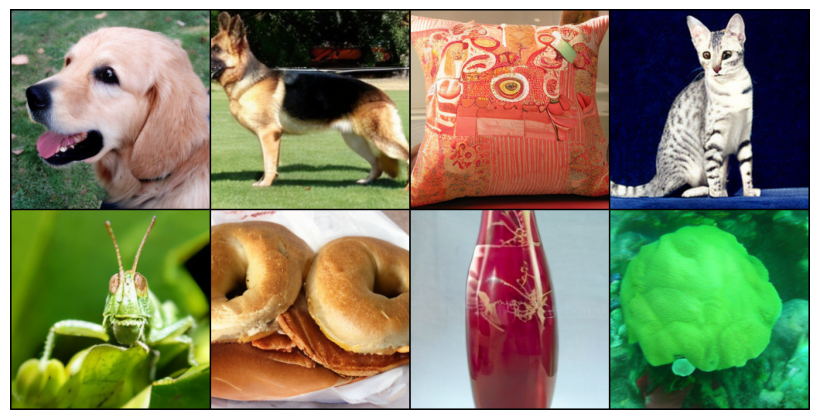

In [13]:
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample_swa.png", nrow=4, normalize=True, value_range=(-1, 1))
display_image("sample_swa.png")

### 2.5 Let's create a grafted model (50% self-attention replaced with Hyena-Y)

#### 2.5.1 Install causal-conv1d

In [7]:
!git clone https://github.com/Dao-AILab/causal-conv1d.git
!git config --global --add safe.directory /home/demo_notebooks/causal-conv1d
!cd causal-conv1d && \
git checkout f8c2467 && \
pip install . > check_causal-conv1d.txt 2>&1

fatal: destination path 'causal-conv1d' already exists and is not an empty directory.
HEAD is now at f8c2467 Bump to v1.4.0


In [ ]:
# These parameters define our model configuration. 
# Print the model below to see the grafted components 
# Look for the swapped attention blocks in the transformer (See transformer block indexes 1, 3, 5, 7, ...27).
config_filepath = './demo_configs/50p_hyena_y.yaml'
config = load_yaml_file(config_filepath)

dit_model_name = config['sample_config']['dit_model_name']
dit_ckpt_path = config['sample_config']['grafted_dit_ckpt_path']
dit_ckpt_path = None if dit_ckpt_path=="None" else dit_ckpt_path
image_size = config['sample_config']['image_size']
graft_indexes = config['sample_config']['graft_indexes']
graft_weights = config['sample_config']['graft_weights']
graft_weights = {} if graft_weights==None else graft_weights
operator_type = config['operator']['type']
operator_name = config['operator']['name']
operator_config_filepath = config['operator']['config_filepath']
seed = config['sample_config']['seed']

# Set seed
torch.manual_seed(seed)

model_hyena_y = graft_dit(dit_model_name, dit_ckpt_path, image_size, operator_type, operator_name, operator_config_filepath, 
                    graft_indexes, graft_weights, run_all_unit_tests=False).to(device)
# print(model_hyena_y) # Uncomment this the inspect the model.

In [ ]:
# Sample images:
with torch.inference_mode():
    with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
        samples = diffusion.p_sample_loop(
            model_hyena_y.forward_with_cfg, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=True, device=device
        )

In [ ]:
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# # Save and display images:
save_image(samples, "sample_hyena_y.png", nrow=4, normalize=True, value_range=(-1, 1))
display_image("sample_hyena_y.png")

##  Interpreting Results and Future Directions

The grafting results you've explored demonstrate the effectiveness of this simple yet powerful architecture editing approach. 

#### Future Directions
Grafting holds promise for many practical applications where efficiency matters:

- Resolution Scaling: Adapting models from low-resolution to high-resolution settings.
- Extending capabilities from short-form to long-form video understanding and generation.
- Improving user experience in real-time applications like image editing, where even modest speedups (10%+) are highly valued.
- Tailoring Models: Customizing architectures for different hardware configurations (GPUs, TPUs, mobile devices) by grafting hardware-optimized components.

We hope this exploration encourages the community to actively explore new architecture designs through grafting.